# Product Recognition on Store Shelves

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import itertools
from math import radians, cos, sin
import os

In [2]:
def print_image_path(image_path):
    '''
    Print an image specifying its filepath
    Args:
        image: image filepath in string format
    '''
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Optional: Turn off axis labels and ticks
    plt.show()

def print_image(image, type='bgr'):
    '''
    Print a grayscale or bgr image read with OpenCV
    Args:
        image: opencv image
    '''
    if type == 'bgr':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif type == 'gray':
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
    plt.imshow(image)
    plt.axis('off')  # Optional: Turn off axis labels and ticks
    plt.show()

## STEP A - Multiple Product Detection

Develop an object detection system to identify single instance of products given: one reference image for each item and a scene image. The system should be able to correctly identify all the product in the shelves image.

* The images with the products that must be detected are: *models/{0,1,11,19,24,25,26}.jpg*
* The test images are: *scenes/e{1,2,3,4,5}.png*

### Step A - Some utility functions

In [3]:
# CONSTANTS used for images, keypoints, descriptors (returned by get_keypoints_and_descriptors())
ID = 0
KP = 1
DES = 2
HUE = 3

# CONSTANTS used for width, heigth and centroid of objects found in the scene (returned by find_match())
CENTER = 0
WIDTH = 1
HEIGHT = 2


def extract_id_from_path(string):
    '''
    Given a full or local path of a file, it extracts the filename excluding the extension.

    Args:
        string: a path string such as "model/0.jpg" or "e1.jpg"

    Returns:
        string: the name of the file without the extension
    '''

    if "/" in string:
        string = string.split('/')[-1]
    if "." in string:
        string = string.split('.')[0]
    return string

def extract_product_position(points):

    # calculate central position of the object
    c_obj = tuple(np.int32(points.mean(axis=0)).ravel())
    
    # width of the object (euclidean norm of the vector)
    w_obj = int(np.linalg.norm(points[1].ravel() - points[2].ravel()))
    
    # height of the object (euclidean norm of the vector)
    h_obj = int(np.linalg.norm(points[0].ravel() - points[1].ravel()))
    
    return (c_obj, w_obj, h_obj)

### Step A - The system

The class Simple_Finder will be used to perform a the detection of multiple products in a scene image.

In [4]:
class Simple_Finder:

    def __init__(self, paths_im, use_flann=False):
        '''
        Saves the images and their descriptors (id, kp, des) in local structures, to improve the 
        reusability of the data during the detection process. It also initialize the Flann matcher.
        '''
        if use_flann:
            self.matcher = self.initialize_flann()
        else:
            self.matcher = cv2.BFMatcher()
        
        # sift detector used on the model images
        self.sift_m = cv2.SIFT_create(nfeatures=0, nOctaveLayers=6, contrastThreshold=0.09, edgeThreshold=10, sigma=5.6)
        # sift detector used on the scene images
        self.sift_s = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=10, sigma=2.6)
        
        self.lowe_ratio_distance = 0.8
        self.MIN_MATCH_COUNT = 30
        self.MIN_MATCH_PERC = 0.24
        
        # get the list of products (with keypoints and descriptors) and their images
        self.prods_st, self.images = self.get_keypoints_and_descriptors(paths_im, self.sift_m, mask=None)


    def initialize_flann(self):
        '''Initializes the flann matcher with some default parameters'''
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        return cv2.FlannBasedMatcher(index_params, search_params)

    def get_keypoints_and_descriptors(self, paths_im, sift=None, mask=None):
        '''
        Given a list of image paths and a mask, the method detects the keypoints and computes
        their descriptors. It returns a specific tuple.

        Args:
            paths_im:   paths of the images
            mask:       mask that filters the image space in which to search for keypoints

        Returns:
            prod_st:    list of tuples, composed as follows (product_id, keypoints, descriptions)
                            the product_id is extracted by the image filename.
            images:     list of the images read saved on disk
        '''

        if sift is None:
            # create the SIFT object and the Flann matcher
            sift = cv2.SIFT_create()

        prod_st = []        # empty list for the informations (id, keypoints, description)
        images = []         # empty list for the images
        for path in paths_im:
            im = cv2.imread(path)
            images.append(im)

            kp, des = sift.detectAndCompute(im, mask)
            product_id = extract_id_from_path(path)

            # append to the list a tuple that describes the product
            prod_st.append((product_id, kp, des))
        
        return prod_st, images

    def find_match(self, product_st, scene_st, image):
        '''
        Given the KEYPOINTS, DESCRIPTIONS, IMAGE of model and train image (Product and Scene), 
        the function tries to find if the model is present in the train image

        Args:
            product_st:     the structure (id,kp,des) of the products
            scene:          the structure (id,kp,des) of the scene
            image:          product's image

        Returns:
            r_list:         list of coordinates of products mapped in the scene
        '''

        r_list = []

        # Matching the descriptors
        matches = self.matcher.knnMatch(product_st[DES],scene_st[DES],k=2)

        # Keeping only good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < self.lowe_ratio_distance*n.distance:
                good.append(m)

        # We find the box of the object if the number of matches is more than a specific value,
        # based on a percentage of the previously found number of product's keypoints.
        # This ensures that the threshold doesn't penalizes products with a lower number of keypoints
        if len(good) > (self.MIN_MATCH_PERC*len(product_st[KP])):
            src_pts = np.float32([ product_st[KP][m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ scene_st[KP][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            
            # Calculating homography based on correspondences
            M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            
            # Apply homography to project corners of the query image into the image
            h,w = image.shape[0:2]
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)

            # for each found product, we save the scene bounding box points
            r_list.append(dst)

        return r_list


    def analyze_scene(self, path_scene):
        '''
        Given the path of a scene, the function searches for 
        the products in the scene by calling find_match().

        Args:
            path_scene: optional - paths of the scene image source

        Returns:
            description:    a string description of which products were found in the scene
            scene_bbox:     the scene image with the bounding box around the detected products
        '''

        if path_scene is None:
            print("ERROR: you must provide the path of a scene, to analyze it")
            return
        
        # get the keypoints and descriptors of the scene image
        scene_st, scene_im = self.get_keypoints_and_descriptors([path_scene], self.sift_s, None)
        # the method provides a list, but we analyze one image -> we get the first element.
        scene_st = scene_st[0]
        scene_im = scene_im[0]

        # create a string for the final report
        str = ""
        
        # scene image with products bounding box
        scene_bbox = scene_im.copy()

        for i in range(len(self.images)):
            
            # search for a single product in the scene
            points_in_scene = self.find_match(self.prods_st[i], scene_st, self.images[i])

            # Drawing bounding box
            for instance in points_in_scene:
                scene_bbox = cv2.polylines(scene_bbox,[np.int32(instance)],True,255,3, cv2.LINE_AA)
                found_pos = extract_product_position(instance)
                str += "Product {} - {} instance found:\n".format(self.prods_st[i][ID], len(points_in_scene))
                str += "\tInstance {} {{position: {}, width: {}px, height: {}px}}\n".format(len(found_pos), found_pos[CENTER], found_pos[WIDTH], found_pos[HEIGHT])

        return str, scene_bbox

### Step A - execution
The following code performs the main execution of the Step A activity. A report containing a description of each product found in every scene will be printed and saved on disk.

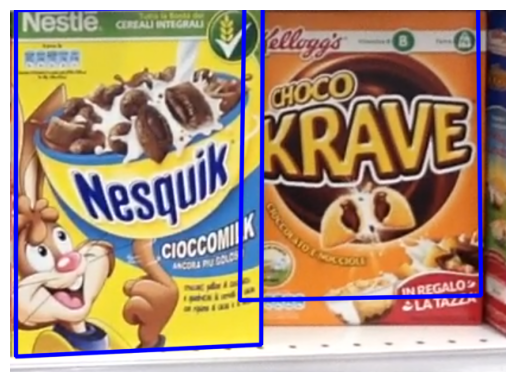

Scene: scenes/e1.png:
Product 0 - 1 instance found:
	Instance 3 {position: (162, 214), width: 309px, height: 437px}
Product 11 - 1 instance found:
	Instance 3 {position: (443, 170), width: 305px, height: 392px}




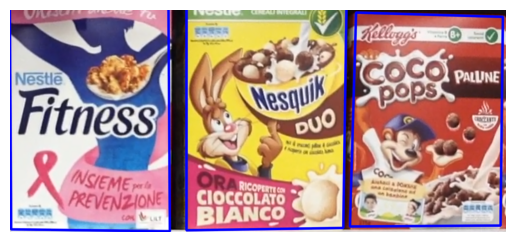

Scene: scenes/e2.png:
Product 24 - 1 instance found:
	Instance 3 {position: (167, 219), width: 334px, height: 490px}
Product 25 - 1 instance found:
	Instance 3 {position: (878, 233), width: 317px, height: 449px}
Product 26 - 1 instance found:
	Instance 3 {position: (538, 218), width: 330px, height: 490px}




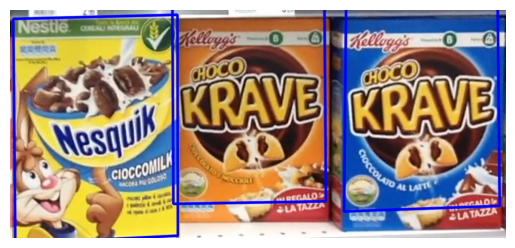

Scene: scenes/e3.png:
Product 0 - 1 instance found:
	Instance 3 {position: (171, 235), width: 323px, height: 444px}
Product 1 - 1 instance found:
	Instance 3 {position: (818, 193), width: 308px, height: 409px}
Product 11 - 1 instance found:
	Instance 3 {position: (474, 186), width: 303px, height: 395px}




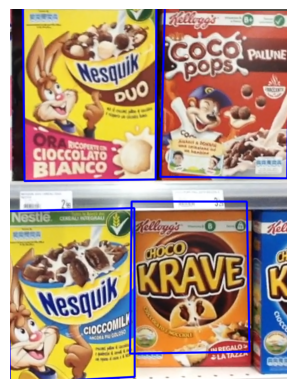

Scene: scenes/e4.png:
Product 0 - 1 instance found:
	Instance 3 {position: (158, 738), width: 323px, height: 444px}
Product 11 - 1 instance found:
	Instance 3 {position: (462, 692), width: 308px, height: 393px}
Product 25 - 1 instance found:
	Instance 3 {position: (555, 210), width: 326px, height: 451px}
Product 26 - 1 instance found:
	Instance 3 {position: (205, 195), width: 337px, height: 495px}




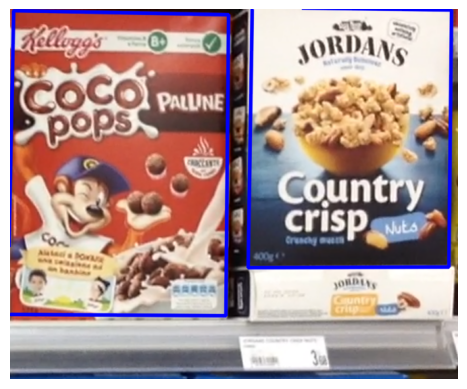

Scene: scenes/e5.png:
Product 19 - 1 instance found:
	Instance 3 {position: (503, 190), width: 296px, height: 386px}
Product 25 - 1 instance found:
	Instance 3 {position: (161, 229), width: 323px, height: 448px}




In [5]:
## Main Code for the STEP A solution.
def step_A(p_images, p_scenes, report_path, verbose=False):
        '''
        Given the image paths of many products and scenes, the function tries to find if the products are present in the scene
        and saves the search results in the file specified by the report_path argument.

        Args:
            p_images:       list of products images paths
            p_scenes:       list of scenes images paths
            report_path:    path for the textual report file
            verbose:        if True, it also prints the report on terminal
        '''

        ## specify the file path where to print a full report of the analysis
        if report_path is None:
            print("Error: You must specify a report path")
            return

        # the system object used to perform the search during Step A.
        system = Simple_Finder(p_images, use_flann=False)
        
        with open(report_path, 'w') as file:

            for path_scene in p_scenes:
                
                str, scene_bbox = system.analyze_scene(path_scene)
                
                r_str = "Scene: {}:\n".format(path_scene) + str
                file.write(r_str)
                file.write("\n\n")

                if verbose:
                    print_image(scene_bbox)
                    print(r_str)
                    print()

        return


paths_images = ['models/{}.jpg'.format(i) for i in {0,1,11,19,24,25,26}]
paths_scenes = ['scenes/e{}.png'.format(i) for i in {1,2,3,4,5}]

step_A(paths_images, paths_scenes, "report_step_A.txt", verbose=True)

### Step B - execution
The following code performs the main execution of the Step B activity. A report containing a description of each product found in every scene will be printed and saved on disk.

For this task, the system must be able to find multiple products, even in multiple instances in the same scene image.

In [6]:
class My_KeyPoint():
    '''
    This class wraps a keypoint and its joining vector to the barycentre of the image.
    It is used to build the Star Model of a product image, for the Hough Accumulator.
    '''
    def __init__(self, keypoint: cv2.KeyPoint, joining_vector):
        self.keypoint = keypoint
        self.vector = joining_vector


class Product_Model_GHT():
    '''
    This class contains the Star Model of a product image, to be used along with the
    Generalized Hough Transform. It contains an identificative of the product, the centroid
    of the keypoints, the keypoints, their descriptors, and an histogram that describes the
    image. For this project, the histogram is the Hue channel of the image converted in HSV
    format, and it is used to calculate the Color Similarity between two images.
    '''
    def __init__(self, identificator, keypoints: list[cv2.KeyPoint], descriptors, hist):
        
        self.id = identificator
        self.set_centroid_and_vectors(keypoints)
        self.descriptors = descriptors
        self.hist = hist


    def set_centroid_and_vectors(self, keypoints: list[cv2.KeyPoint]):

        # calculate the reference point (barycenter)
        self.centroid = np.float32([ kp.pt for kp in keypoints ]).reshape(-1,1,2).mean(axis=0, dtype=np.int32)[0]
        
        # for each keypoint calculate the vector between it and the barycenter
        self.keypoints = []
        for kp in keypoints:
            vect = np.array(self.centroid - kp.pt)
            self.keypoints.append(My_KeyPoint(kp, vect))


class Accumulator():
    '''
    This class instances an Accumulator, which is used to collect votes casted by the
    found keypoints, by using the Generalized Hough Transform.
    '''
    def __init__(self, train_image, 
                 bins_dx=100, bins_dy=50, bins_ds=5, bins_dtheta=4,
                 s_max=1.0, s_min=0.1, r_max=360, r_min=0, clean_r=3):
        
        '''Instances the accumulator based on the parameter's configs'''

        width = train_image.shape[1]
        height = train_image.shape[0]
        
        dx_span = int(width / bins_dx)+1
        dx_range = [(x,x+dx_span) for x in np.arange(0, width, dx_span)]

        dy_span = int(height / bins_dy)+1
        dy_range = [(x,x+dy_span) for x in np.arange(0, height, dy_span)]
        
        ds_span = (s_max-s_min) / bins_ds 
        ds_range = [(x,x+ds_span) for x in np.arange(s_min, s_max, ds_span)]

        dt_span = (r_max-r_min) / bins_dtheta
        dt_range = [(x,x+dt_span) for x in np.arange(-180, 180, dt_span)]

        self.dx_range = dx_range
        self.dy_range = dy_range
        self.ds_range = ds_range
        self.dt_range = dt_range
        
        self.dx_span = dx_span
        self.dy_span = dy_span
        self.ds_span = ds_span
        self.dt_span = dt_span

        self.bins_dx = bins_dx
        self.bins_dy = bins_dy
        self.bins_ds = bins_ds
        self.bins_dt = bins_dtheta

        self.clean_r = clean_r
        self.accumulator = np.zeros((bins_dy, bins_dx, bins_ds, bins_dtheta), dtype=np.int32)


    def threshold(self, th):
        '''Thresholds the accumulator, setting every bin below the threshold to zero'''
        self.accumulator = np.where(self.accumulator >= th, self.accumulator, 0)


    def reset(self):
        self.accumulator = np.zeros((self.bins_dy, self.bins_dx, self.bins_ds, self.bins_dt), dtype=np.int32)


    def get_bin(self, val, bins_range):
        '''
        This method returns the bin corresponding to the given value.
        Args:
            val: the value for which you want to search the correct bin
            bins_range: the array of tuples corresponding to the bins' ranges
        '''
        idx = 0
        for min,max in bins_range:
            if val >= min and val < max:
                return idx
            idx += 1
        
        if val < bins_range[0][0]:
            return 0
        else:
            return len(bins_range)-1


    def accumulate(self, query: My_KeyPoint, train: cv2.KeyPoint):
        '''
        Cast a vote in the accumulator.
        Args:
            query: query image's keypoint
            train: train image's keypoint
        Returns:
            the tuple with the voted bin's index
        '''
        vect = query.vector  # joining vector: from the keypoint to the reference point
        
        query = query.keypoint
        train = train

        # scale ratio between the two keypoints
        scale_f = train.size / query.size

        # difference in rotation
        rot_f = train.angle - query.angle
        rot_f = radians(rot_f)
        
        ccos = cos(rot_f)
        ssin = sin(rot_f)
        rotation = np.float32([[ccos, ssin],[-ssin,ccos]])

        # calculate the predicted centroid
        c = np.int32(train.pt + rotation.dot(scale_f*vect))
 
        # cast a vote in the right accumulator's bin
        x = self.get_bin(c[0], self.dx_range)
        y = self.get_bin(c[1], self.dy_range)
        
        s = self.get_bin(scale_f, self.ds_range)
        r = self.get_bin(rot_f, self.dt_range)
        
        self.accumulator[y,x,s,r] += 1
        return (y,x,s,r)
    
    
    def clean_neighborhood(self, acc_point):
        '''
        This method cleans the neighbourhood of a bin.
        '''
        r = self.clean_r
        near_moves = list(itertools.product(set(range(-r,r+1,1)), repeat = 4))
        near_bins = np.array(near_moves) + np.array(acc_point)

        for bin in near_bins:
            if self.is_in_bounds(bin):
                y,x,s,r = bin
                self.accumulator[y,x,s,r] = 0


    def reset_point(self, point):
        y,x,s,r = point
        self.accumulator[y,x,s,r] = 0


    def is_in_bounds(self, point):
        y,x,s,r = point
        if y >= 0 and y < self.bins_dy:
            if x >= 0 and x < self.bins_dx:
                if s >= 0 and s < self.bins_ds:
                    if r >= 0 and r < self.bins_dt:
                        return True
        return False

In [7]:
class Mega_Finder():

    def __init__(self, paths_im, use_flann=False, use_orb=False, normalize_hist=False, verbose=False, debug=False,
                 lowe_ratio_distance=0.8, min_match_count=4, sim_th=0.4, hist_size=64, norm_type=cv2.NORM_L2,
                 sift_s=None, sift_m=None, prod_height=160, scene_scaling=1,
                 sc_bins_dx=0.12, sc_bins_dy=0.12, bins_ds=4, bins_dtheta=8, s_max=1.0, s_min=0.1, r_max=360, r_min=0, clean_r=3):
        '''
        Saves the images and their descriptors (id, kp, des) in local structures, to improve the 
        reusability of the data during the detection process. It also initialize the Flann matcher.
        '''
        if use_flann:
            self.matcher = self.initialize_flann()
        else:
            self.matcher = cv2.BFMatcher()
        if use_orb:
            orb = cv2.ORB_create(nfeatures=1400, scaleFactor=1.2, nlevels=10, edgeThreshold=15, WTA_K=3, patchSize=10, fastThreshold=10)
            self.sift_m = orb
            orb_s = cv2.ORB_create(nfeatures=20000, scaleFactor=1.2, nlevels=10, edgeThreshold=15, WTA_K=3, patchSize=10, fastThreshold=5)
            self.sift_s = orb_s
        else:
            sift = cv2.SIFT_create(nfeatures=0, nOctaveLayers=6, contrastThreshold=0.08, edgeThreshold=15, sigma=2.4)
            self.sift_m = sift_m if sift_m != None else sift
            sift = cv2.SIFT_create(nOctaveLayers=6, contrastThreshold=0.07, edgeThreshold=10, sigma=1.2)
            self.sift_s = sift_s if sift_s != None else sift
            
        self.verbose = verbose
        self.debug = debug

        # accumulator parameters
        self.sc_bins_dx = sc_bins_dx
        self.sc_bins_dy = sc_bins_dy
        self.bins_ds = bins_ds
        self.bins_dtheta = bins_dtheta
        self.s_max = s_max
        self.s_min = s_min
        self.r_max = r_max
        self.r_min = r_min
        self.clean_r = clean_r

        self.lowe_ratio_distance = lowe_ratio_distance
        self.MIN_MATCH_COUNT = min_match_count
        self.similarity_th = sim_th
        self.hist_size = hist_size
        self.normalize_hist = normalize_hist
        self.norm = norm_type

        self.prod_height=prod_height
        self.scene_scaling=scene_scaling

        self.suff_points = 200

        prods_st, self.images = self.get_keypoints_and_descriptors(paths_im, self.sift_m, mask=None, d_height=prod_height, interp_type=cv2.INTER_AREA)
        if debug:
            for prod in prods_st:
                print("id:{} - n° keypoints:{}".format(prod[ID], len(prod[KP])))
        
        for i in range(len(self.images)):
            hsv = cv2.cvtColor(self.images[i], cv2.COLOR_BGR2HSV)
            hist = cv2.calcHist([hsv], [0], None, [self.hist_size], [0, 180])
            if self.normalize_hist:
                hist = cv2.normalize(hist, hist, norm_type=self.norm)
            prods_st[i].append(hist)
        
        if debug:
            sift_paths = ["models_keypoints/{}.jpg".format(extract_id_from_path(filepath)) for filepath in paths_im]
            gray_paths = ["models_gray/{}.jpg".format(extract_id_from_path(filepath)) for filepath in paths_im]
            
            for sift_p, gray_p, image, prod in zip(sift_paths, gray_paths, self.images, prods_st):
                image_with_keypoints = cv2.drawKeypoints(image,prod[KP],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                cv2.imwrite(sift_p, image_with_keypoints)
                image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(gray_p, image_gray)
        
        self.prods_st = [Product_Model_GHT(prod[ID], prod[KP], prod[DES], prod[HUE]) for prod in prods_st] 


    def initialize_flann(self):
        '''Initializes the flann matcher with some default parameters'''
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
        search_params = dict(checks = 150)
        return cv2.FlannBasedMatcher(index_params, search_params)


    def get_keypoints_and_descriptors(self, paths_im, sift, mask=None, d_width=None, d_height=None, scaling=1, interp_type=cv2.INTER_LINEAR):
        '''
        Given a list of image paths and a sift detector, the method detects the keypoints and computes
        their descriptors. It returns a specific tuple. The images can be scaled and resized.

        Args:
            paths_im:       paths of the images
            sift:           the SIFT detector
            mask:           mask that filters the space in which to search for keypoints
            d_width:        new width of the image
            d_height:       new height of the image
            scaling:        scaling factor for image resizing
            interp_type:    type of interpolation for the resizing
            
        Returns:
            prod_st:    list of tuples - (product_id, keypoint, description)
                            the product_id is extracted by the image filename.
            images:     list of the images read by disk
        '''

        if sift is None:
            # create the SIFT object and the Flann matcher
            sift = cv2.SIFT_create()

        prod_st = []        # empty list for the informations (id, keypoints, description)
        images = []         # empty list for the images
        resized_dim = ()
        for path in paths_im:
            im = cv2.imread(path)
        
            if d_width != None:
                if d_height != None:
                    resized_dim = (d_width, d_height)
                else:
                    heigth_to_width = im.shape[0]/im.shape[1]
                    resized_dim = (d_width, int(im.shape[0]*heigth_to_width))
            else:
                if d_height != None:
                    width_to_height = im.shape[1]/im.shape[0]
                    resized_dim = (int(width_to_height*d_height), d_height)
                else:
                    resized_dim = (int(im.shape[1]*scaling), int(im.shape[0]*scaling))
            
            # resize image
            im = cv2.resize(im, resized_dim, interpolation = interp_type)
        
            images.append(im)

            kp, des = sift.detectAndCompute(im, mask)
            product_id = extract_id_from_path(path)

            # append to the list a tuple that describes the product
            prod_st.append([product_id, kp, des])
        
        return prod_st, images
    

    def find_match(self, product_st: Product_Model_GHT, prod_im, scene_im, scene_mask):
        '''
        Given the Product's Star Model, the function tries to find if the model is present in the train image

        Args:
            product_st:     a Product_Model_GHT instance
            prod_im:        product's image
            scene_im:       scene's image
            scene_mask:     scene's background mask

        Returns:
            r_list:         list of coordinates of products mapped in the scene
        '''
        r_list = []
        
        h_sc = scene_im.shape[0]
        w_sc = scene_im.shape[1]
        accumulator = Accumulator(scene_im,
                                    bins_dx=int(w_sc*self.sc_bins_dx),
                                    bins_dy=int(h_sc*self.sc_bins_dy),
                                    bins_ds=self.bins_ds,
                                    bins_dtheta=self.bins_dtheta,
                                    s_max=self.s_max,
                                    s_min=self.s_min,
                                    r_max=self.r_max,
                                    r_min=self.r_min,
                                    clean_r=self.clean_r)

        scene_kp, scene_des = self.sift_s.detectAndCompute(scene_im, scene_mask)

        # Matching the descriptors
        matches = self.matcher.knnMatch(product_st.descriptors,scene_des,k=2)

        # Keeping only good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < self.lowe_ratio_distance*n.distance:
                good.append(m)

        more = True

        keypoints_in_bins = dict()
        for i in range(len(good)):
            prod_kp = product_st.keypoints[good[i].queryIdx]
            scen_kp = scene_kp[good[i].trainIdx]
            
            bin = accumulator.accumulate(prod_kp, scen_kp)
            if bin in keypoints_in_bins.keys():
                keypoints_in_bins.get(bin).append(i)
            else:
                keypoints_in_bins[bin] = [i]

        if self.debug:
            print("model: {}, max: {}".format(product_st.id, accumulator.accumulator.max()))
        accumulator.threshold(self.MIN_MATCH_COUNT)
        while(more):
    
            max_point = np.unravel_index(accumulator.accumulator.argmax(), accumulator.accumulator.shape)
    
            match_ids = keypoints_in_bins.get(max_point)
            needed_kps = self.MIN_MATCH_COUNT
            
            #if match_ids is None or len(match_ids) < 4 or len(match_ids) < needed_kps: more = False
            
            if self.debug:
                print("-- point: {}, numpoints: {}, needed: {}, more: {}".format(max_point, len(match_ids) if match_ids is not None else "[]", needed_kps, more))
            if accumulator.accumulator[max_point] == 0: break

            if more:
                keypoints_in_bins.get(max_point)
                src_pts = [product_st.keypoints[good[id].queryIdx].keypoint.pt for id in match_ids] 
                dst_pts = [scene_kp[good[id].trainIdx].pt for id in match_ids]
            
                src_pts = np.float32(src_pts).reshape(-1,1,2)
                dst_pts = np.float32(dst_pts).reshape(-1,1,2)
                
                # Calculating homography based on correspondences
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 7.0)
                if M is None: break
                
                # Apply homography to project corners of the query image into the image
                h,w = prod_im.shape[0:2]
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                dst = cv2.perspectiveTransform(pts,M)
                #print("shape: {}".format(np.int32(dst)))
                
                
                #mask = np.ones_like(scene_im[:,:,0], dtype=np.int8)*255
                mask = cv2.cvtColor(scene_im, cv2.COLOR_BGR2GRAY)
                mask[:,:] = 0
                sc_masked = np.ones_like(scene_im)*255
                sc_masked = cv2.cvtColor(scene_im, cv2.COLOR_BGR2GRAY)
                sc_masked = cv2.fillPoly(sc_masked,[np.int32(dst)],0, cv2.LINE_AA)
                #mask = cv2.polylines(mask,[np.int32(dst)],True,255,3, cv2.LINE_AA)
                mask = cv2.fillPoly(mask,[np.int32(dst)],255, cv2.LINE_AA)
                
                #print_image(sc_masked, 'gray')
                #print_image(mask, 'gray')

                # Drawing bounding box
                hsv = cv2.cvtColor(scene_im, cv2.COLOR_BGR2HSV)
                #sc_hist = cv2.calcHist([hsv], [0,1], mask, [32, 32], [0,180,0,256])
                sc_hist = cv2.calcHist([hsv], [0], mask, [self.hist_size], [0,180])
                if self.normalize_hist:
                    sc_hist = cv2.normalize(sc_hist, sc_hist, norm_type=self.norm)
                #print("hist shape {}".format(sc_hist.shape))
                #print(sc_hist)
                pr_hist = product_st.hist.flatten()
                sc_hist = sc_hist.flatten()
                similarity = np.dot(pr_hist, sc_hist) / (np.linalg.norm(pr_hist) * np.linalg.norm(sc_hist))
                if self.debug:
                    print(similarity)
                if similarity >= self.similarity_th or len(match_ids) > self.suff_points:
                    r_list.append(dst)
                    scene_mask[mask == 255] = 0
                else:
                    if self.debug:
                        print("---> rejected")
                accumulator.clean_neighborhood(max_point)
                #accumulator.reset_point(max_point)
        return r_list, scene_mask

    
    def analyze_scene(self, scene_im):
        '''
        Given the scene's image, the function searches for 
        the products in the scene by calling find_match().

        Args:
            scene_im:       scene image

        Returns:
            str:            a string description of which products were found in the scene
            scene_bbox:     the scene image with the bounding box around the detected products
        '''
        
        ## create a string for the final report
        str = ""
        
        # scene image with products bounding box
        scene_bbox = scene_im.copy()
        
        mask = cv2.cvtColor(scene_im, cv2.COLOR_BGR2GRAY)
        mask[:,:] = 255

        for i in range(len(self.images)):
            
            # search for a single product in the scene
            instances, mask = self.find_match(self.prods_st[i], self.images[i], scene_im, mask)
            instance_count = 0
            if len(instances) > 0:
                str += "Product {} - {} instance found:\n".format(self.prods_st[i].id, len(instances))
    
            for points in instances:
                # Drawing bounding box
                
                scene_bbox = cv2.polylines(scene_bbox,[np.int32(points)],True,(255,0,0),3, cv2.LINE_AA)
                found_pos = extract_product_position(points)
                
                str += "\tInstance {} {{position: {}, width: {}px, height: {}px}}\n".format(instance_count, found_pos[CENTER], found_pos[WIDTH], found_pos[HEIGHT])
                instance_count += 1

        return str, scene_bbox

In [8]:
def step_execution(system, paths_scenes, report_path, verbose=False):
    i = 0
    with open(report_path, 'w') as file:

        for path_scene in paths_scenes:
            
            # get the keypoints and descriptors of the scene image
            scene_st, scene_im = system.get_keypoints_and_descriptors([path_scene], system.sift_s, mask=None, scaling=system.scene_scaling)
            # the method provides a list, but we analyze one image -> get the first element.
            scene_st = scene_st[0]
            scene_im = scene_im[0]

            sift_path = "scenes_keypoints/{}.png".format(extract_id_from_path(path_scene))
            gray_path = "scenes_gray/{}.png".format(extract_id_from_path(path_scene))

            image_with_keypoints = cv2.drawKeypoints(scene_im,scene_st[KP],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            cv2.imwrite(sift_path, image_with_keypoints)
            image_gray = cv2.cvtColor(scene_im, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(gray_path, image_gray)

            str, scene_bbox = system.analyze_scene(scene_im)
            
            r_str = "Scene: {}:, n° keypoints: {}\n".format(path_scene, len(scene_st[KP])) + str
            file.write(r_str)
            file.write("\n\n")

            if verbose:
                print_image(scene_bbox)
                print(r_str)
                print()
            i += 1

Here we test the Mega_Finder for the Step B task.

In [9]:
# Define some parameters
verbose=True
debug=False

paths_images = ['models/{}.jpg'.format(i) for i in {0,11,1,19,24,25,26}]
paths_scenes = ['scenes/m{}.png'.format(i) for i in {1,2,3,4,5}]

acc_params = dict(sc_bins_dx= 0.15,
                    sc_bins_dy= 0.15,
                    bins_ds= 4,
                    bins_dtheta= 1,
                    clean_r=3)

sift_m = cv2.SIFT_create(nfeatures=0, nOctaveLayers=6, contrastThreshold=0.09, edgeThreshold=12, sigma=1.2)
sift_s = cv2.SIFT_create(nOctaveLayers=6, contrastThreshold=0.07, edgeThreshold=12, sigma=1.2)

sift_params = dict(sift_s=sift_s, sift_m=sift_m)

scene_scaling=0.35

# Create the System
system = Mega_Finder(paths_images, use_flann=True, use_orb=False, normalize_hist=True, verbose=verbose, debug=debug, hist_size=32, lowe_ratio_distance=0.7, min_match_count=8,
                     sim_th=0.48, prod_height=160, scene_scaling=scene_scaling, **sift_params, **acc_params)

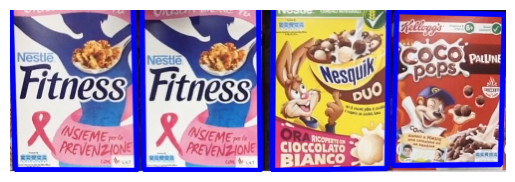

Scene: scenes/m1.png:, n° keypoints: 2632
Product 24 - 2 instance found:
	Instance 0 {position: (192, 76), width: 116px, height: 170px}
	Instance 1 {position: (64, 73), width: 121px, height: 175px}
Product 25 - 1 instance found:
	Instance 0 {position: (440, 79), width: 108px, height: 154px}
Product 26 - 1 instance found:
	Instance 0 {position: (321, 76), width: 115px, height: 170px}




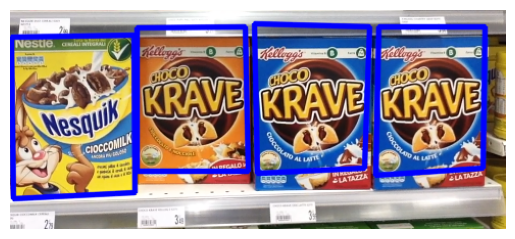

Scene: scenes/m2.png:, n° keypoints: 3099
Product 0 - 1 instance found:
	Instance 0 {position: (62, 104), width: 118px, height: 157px}
Product 1 - 2 instance found:
	Instance 0 {position: (295, 86), width: 105px, height: 145px}
	Instance 1 {position: (411, 88), width: 105px, height: 144px}
Product 11 - 1 instance found:
	Instance 0 {position: (178, 88), width: 108px, height: 140px}




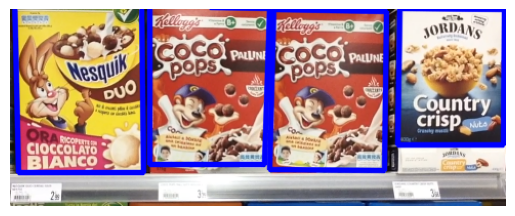

Scene: scenes/m3.png:, n° keypoints: 3124
Product 19 - 1 instance found:
	Instance 0 {position: (430, 65), width: 102px, height: 134px}
Product 25 - 2 instance found:
	Instance 0 {position: (310, 79), width: 112px, height: 155px}
	Instance 1 {position: (193, 74), width: 111px, height: 155px}
Product 26 - 1 instance found:
	Instance 0 {position: (68, 71), width: 121px, height: 176px}




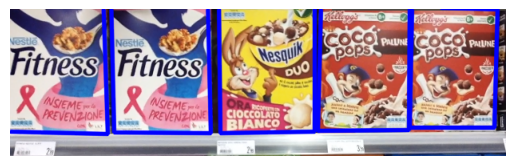

Scene: scenes/m4.png:, n° keypoints: 3167
Product 24 - 2 instance found:
	Instance 0 {position: (188, 68), width: 120px, height: 174px}
	Instance 1 {position: (56, 66), width: 125px, height: 175px}
Product 25 - 2 instance found:
	Instance 0 {position: (555, 73), width: 105px, height: 151px}
	Instance 1 {position: (443, 73), width: 113px, height: 159px}
Product 26 - 1 instance found:
	Instance 0 {position: (322, 68), width: 118px, height: 172px}




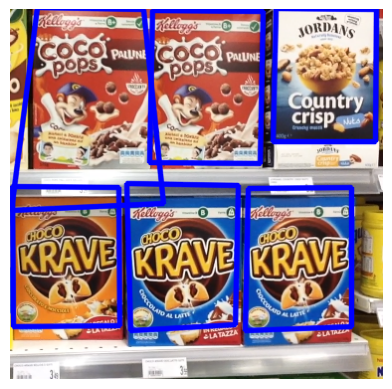

Scene: scenes/m5.png:, n° keypoints: 4467
Product 1 - 2 instance found:
	Instance 0 {position: (173, 248), width: 105px, height: 147px}
	Instance 1 {position: (290, 250), width: 106px, height: 143px}
Product 11 - 1 instance found:
	Instance 0 {position: (56, 248), width: 106px, height: 140px}
Product 19 - 1 instance found:
	Instance 0 {position: (317, 66), width: 103px, height: 134px}
Product 25 - 2 instance found:
	Instance 0 {position: (197, 78), width: 110px, height: 153px}
	Instance 1 {position: (79, 99), width: 152px, height: 205px}




In [10]:
# Object Detection
step_execution(system, paths_scenes, report_path="report_step_B.txt", verbose=verbose)

Here we test the Mega Finder for the Step C task.

In [11]:
# Define some parameters
verbose = True
debug = False

paths_images = ['models/{}.jpg'.format(i) for i in range(24)]
paths_scenes = ['scenes/h{}.jpg'.format(i) for i in [1,2,3,4,5]]

acc_params = dict(sc_bins_dx= 0.09,
                    sc_bins_dy= 0.09,
                    bins_ds= 4,
                    bins_dtheta= 1,
                    clean_r=3)

sift_m = cv2.SIFT_create(nfeatures=0, nOctaveLayers=6, contrastThreshold=0.09, edgeThreshold=8, sigma=1.3)
sift_s = cv2.SIFT_create(nOctaveLayers=6, contrastThreshold=0.09, edgeThreshold=8, sigma=1.3)

sift_params = dict(sift_s=sift_s, sift_m=sift_m)

scene_scaling = 1
prod_height=100

# the system object used to perform the search during Step B.
system = Mega_Finder(paths_images, use_flann=True, use_orb=False, normalize_hist=True, verbose=verbose, debug=debug, hist_size=32, lowe_ratio_distance=0.6, min_match_count=6,
                     sim_th=0.47, prod_height=prod_height, scene_scaling=scene_scaling, **sift_params, **acc_params)

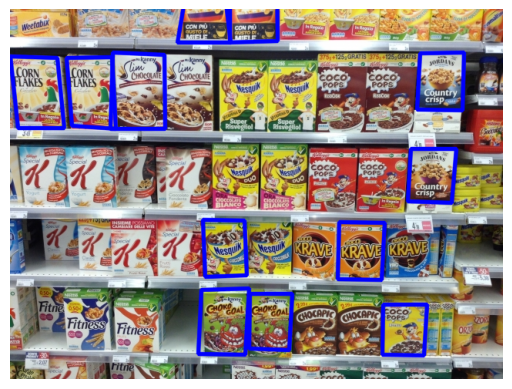

Scene: scenes/h1.jpg:, n° keypoints: 5567
Product 0 - 1 instance found:
	Instance 0 {position: (278, 310), width: 54px, height: 73px}
Product 2 - 2 instance found:
	Instance 0 {position: (106, 108), width: 57px, height: 88px}
	Instance 1 {position: (35, 108), width: 60px, height: 93px}
Product 3 - 2 instance found:
	Instance 0 {position: (277, 405), width: 61px, height: 82px}
	Instance 1 {position: (337, 405), width: 52px, height: 71px}
Product 4 - 1 instance found:
	Instance 0 {position: (166, 106), width: 70px, height: 99px}
Product 11 - 1 instance found:
	Instance 0 {position: (455, 314), width: 57px, height: 73px}
Product 15 - 1 instance found:
	Instance 0 {position: (511, 416), width: 54px, height: 65px}
Product 18 - 1 instance found:
	Instance 0 {position: (547, 216), width: 56px, height: 68px}
Product 19 - 1 instance found:
	Instance 0 {position: (559, 94), width: 58px, height: 72px}
Product 22 - 2 instance found:
	Instance 0 {position: (253, 4), width: 69px, height: 78px}
	Inst

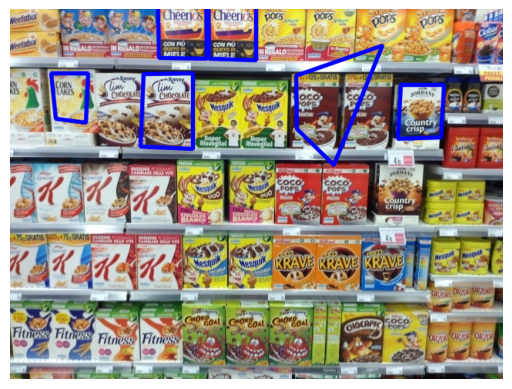

Scene: scenes/h2.jpg:, n° keypoints: 5031
Product 2 - 1 instance found:
	Instance 0 {position: (78, 114), width: 39px, height: 59px}
Product 4 - 1 instance found:
	Instance 0 {position: (204, 132), width: 68px, height: 93px}
Product 7 - 1 instance found:
	Instance 0 {position: (412, 123), width: 67px, height: 69px}
Product 19 - 1 instance found:
	Instance 0 {position: (533, 133), width: 56px, height: 70px}
Product 22 - 2 instance found:
	Instance 0 {position: (223, 16), width: 62px, height: 95px}
	Instance 1 {position: (288, 17), width: 61px, height: 96px}




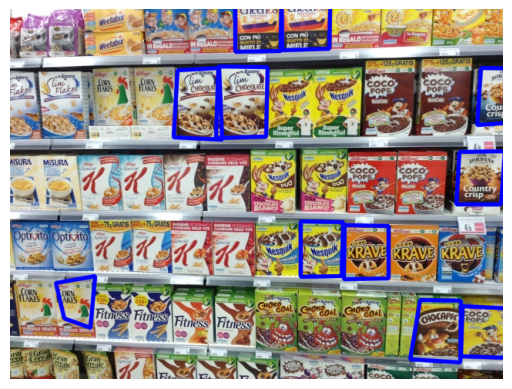

Scene: scenes/h3.jpg:, n° keypoints: 5966
Product 0 - 1 instance found:
	Instance 0 {position: (404, 311), width: 53px, height: 71px}
Product 2 - 1 instance found:
	Instance 0 {position: (86, 379), width: 35px, height: 47px}
Product 4 - 2 instance found:
	Instance 0 {position: (244, 122), width: 62px, height: 87px}
	Instance 1 {position: (300, 120), width: 65px, height: 92px}
Product 11 - 1 instance found:
	Instance 0 {position: (462, 315), width: 58px, height: 69px}
Product 14 - 1 instance found:
	Instance 0 {position: (555, 417), width: 65px, height: 78px}
Product 15 - 1 instance found:
	Instance 0 {position: (615, 419), width: 57px, height: 64px}
Product 18 - 1 instance found:
	Instance 0 {position: (610, 219), width: 58px, height: 68px}
Product 19 - 1 instance found:
	Instance 0 {position: (638, 112), width: 59px, height: 74px}
Product 22 - 2 instance found:
	Instance 0 {position: (322, 8), width: 59px, height: 93px}
	Instance 1 {position: (384, 3), width: 61px, height: 97px}




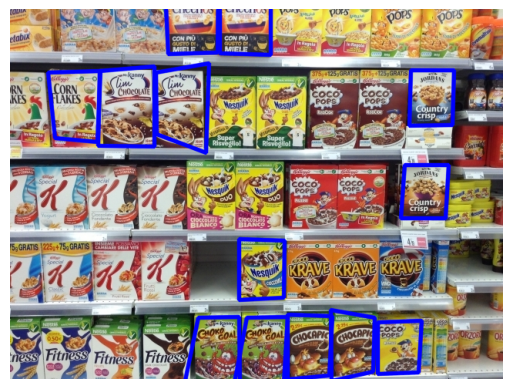

Scene: scenes/h4.jpg:, n° keypoints: 5507
Product 0 - 1 instance found:
	Instance 0 {position: (326, 337), width: 58px, height: 79px}
Product 2 - 1 instance found:
	Instance 0 {position: (84, 125), width: 55px, height: 85px}
Product 3 - 2 instance found:
	Instance 0 {position: (266, 444), width: 72px, height: 92px}
	Instance 1 {position: (328, 442), width: 64px, height: 85px}
Product 4 - 2 instance found:
	Instance 0 {position: (223, 125), width: 68px, height: 79px}
	Instance 1 {position: (151, 127), width: 73px, height: 97px}
Product 14 - 2 instance found:
	Instance 0 {position: (388, 437), width: 55px, height: 83px}
	Instance 1 {position: (445, 435), width: 55px, height: 92px}
Product 15 - 1 instance found:
	Instance 0 {position: (505, 438), width: 53px, height: 66px}
Product 18 - 1 instance found:
	Instance 0 {position: (538, 237), width: 57px, height: 69px}
Product 19 - 1 instance found:
	Instance 0 {position: (547, 115), width: 56px, height: 72px}
Product 22 - 2 instance found:
	I

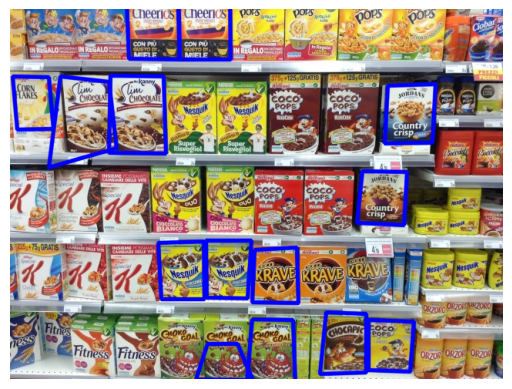

Scene: scenes/h5.jpg:, n° keypoints: 5993
Product 0 - 2 instance found:
	Instance 0 {position: (223, 339), width: 56px, height: 73px}
	Instance 1 {position: (283, 337), width: 53px, height: 73px}
Product 2 - 1 instance found:
	Instance 0 {position: (29, 122), width: 46px, height: 68px}
Product 3 - 2 instance found:
	Instance 0 {position: (340, 444), width: 63px, height: 82px}
	Instance 1 {position: (276, 457), width: 74px, height: 48px}
Product 4 - 2 instance found:
	Instance 0 {position: (165, 137), width: 73px, height: 100px}
	Instance 1 {position: (95, 142), width: 92px, height: 119px}
Product 11 - 1 instance found:
	Instance 0 {position: (344, 346), width: 60px, height: 68px}
Product 14 - 1 instance found:
	Instance 0 {position: (434, 433), width: 60px, height: 79px}
Product 15 - 1 instance found:
	Instance 0 {position: (493, 437), width: 54px, height: 64px}
Product 18 - 1 instance found:
	Instance 0 {position: (483, 245), width: 60px, height: 66px}
Product 19 - 1 instance found:
	

In [12]:
# Object Detection
step_execution(system, paths_scenes, report_path="report_step_C.txt", verbose=verbose)

## Step A, but using the Step C evolved system

In [13]:
# Define some parameters
verbose = True
debug = False

paths_images = ['models/{}.jpg'.format(i) for i in {0,1,11,19,24,25,26}]
paths_scenes = ['scenes/e{}.png'.format(i) for i in {1,2,3,4,5}]

acc_params = dict(sc_bins_dx= 0.15,
                    sc_bins_dy= 0.15,
                    bins_ds= 4,
                    bins_dtheta= 1,
                    clean_r=3)

sift_m = cv2.SIFT_create(nfeatures=0, nOctaveLayers=6, contrastThreshold=0.09, edgeThreshold=12, sigma=1.2)
sift_s = cv2.SIFT_create(nOctaveLayers=6, contrastThreshold=0.09, edgeThreshold=12, sigma=1.2)

sift_params = dict(sift_s=sift_s, sift_m=sift_m)

scene_scaling=1

# Create the system
system = Mega_Finder(paths_images, use_flann=True, use_orb=False, normalize_hist=True, verbose=verbose, debug=debug, hist_size=32,
                     lowe_ratio_distance=0.8, min_match_count=10, sim_th=0.47, prod_height=160, scene_scaling=scene_scaling, **sift_params, **acc_params)

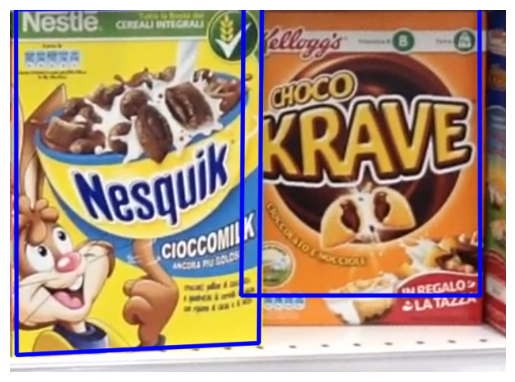

Scene: scenes/e1.png:, n° keypoints: 1346
Product 0 - 1 instance found:
	Instance 0 {position: (162, 213), width: 306px, height: 436px}
Product 11 - 1 instance found:
	Instance 0 {position: (444, 168), width: 302px, height: 388px}




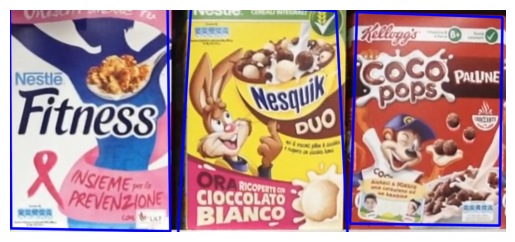

Scene: scenes/e2.png:, n° keypoints: 1760
Product 24 - 1 instance found:
	Instance 0 {position: (167, 219), width: 335px, height: 486px}
Product 25 - 1 instance found:
	Instance 0 {position: (878, 232), width: 315px, height: 444px}
Product 26 - 1 instance found:
	Instance 0 {position: (532, 239), width: 358px, height: 509px}




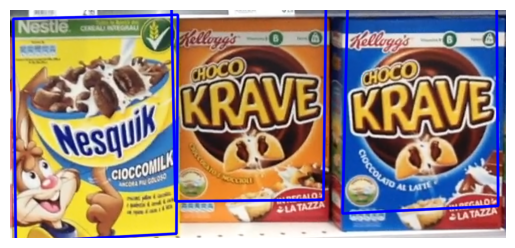

Scene: scenes/e3.png:, n° keypoints: 2104
Product 0 - 1 instance found:
	Instance 0 {position: (170, 234), width: 320px, height: 442px}
Product 1 - 1 instance found:
	Instance 0 {position: (816, 194), width: 309px, height: 413px}
Product 11 - 1 instance found:
	Instance 0 {position: (474, 182), width: 293px, height: 396px}




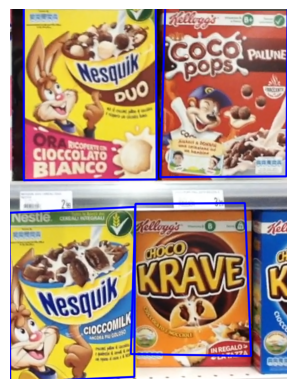

Scene: scenes/e4.png:, n° keypoints: 2690
Product 0 - 1 instance found:
	Instance 0 {position: (160, 738), width: 320px, height: 438px}
Product 11 - 1 instance found:
	Instance 0 {position: (465, 698), width: 310px, height: 388px}
Product 25 - 1 instance found:
	Instance 0 {position: (553, 209), width: 325px, height: 451px}
Product 26 - 1 instance found:
	Instance 0 {position: (206, 197), width: 343px, height: 486px}




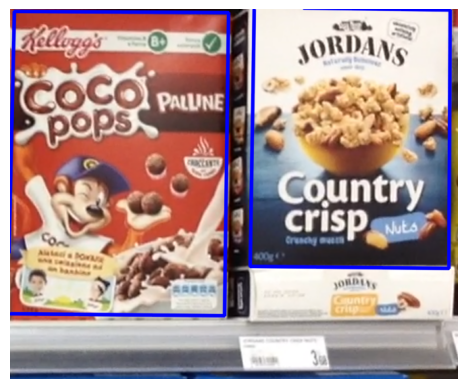

Scene: scenes/e5.png:, n° keypoints: 1265
Product 19 - 1 instance found:
	Instance 0 {position: (504, 190), width: 294px, height: 384px}
Product 25 - 1 instance found:
	Instance 0 {position: (160, 228), width: 322px, height: 446px}




In [14]:
# Object Detection
step_execution(system, paths_scenes, report_path="report_step_A_evo.txt", verbose=verbose)